In [1]:
import numpy as np
from keras.applications import VGG16

import cv2
from PIL import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

class OcclusionExp():
    def __init__(self, image, obstruction_size, stride, model):
        self.image = image
        self.obstruction_size = obstruction_size
        self.stride = stride
        
        # Define variable for ease of access
        self.image_row = image.shape[0]
        self.image_col = image.shape[1]
        self.image_chnl = image.shape[2]
        
        self.obstruction_row = obstruction_size[0]
        self.obstruction_col = obstruction_size[1]
        
        self.stride_row = stride[0]
        self.stride_col = stride[1]
        
        # Define batch size and instantiate batch
        self.batch_size = int(np.ceil((self.image_row-self.obstruction_row)/self.stride_row)) * int(np.ceil((self.image_col-self.obstruction_col)/self.stride_col))
        self.batch = np.zeros((self.batch_size, self.image_row, self.image_col, self.image_chnl))
        
        # Define model
        self.model = model
        
        # Flag to avoid repeatative computation
        self.is_batch_generated = False
    
    def generate_occlusion(self):    
        batch_index = 0

        for row in range(0, self.image_row-self.obstruction_row, self.stride_row):
            for col in range(0, self.image_col-self.obstruction_col, self.stride_col):
                occluded = self.image.copy()
                occluded[row:row+self.obstruction_row, col:col+self.obstruction_col, :] = 0
                self.batch[batch_index,:,:,:] = occluded[:,:,:]
                batch_index += 1

        return self.batch.astype(np.int)
    
    def predict(self):
        class_num = np.argmax(model.predict(self.image.reshape(1, self.image_row, self.image_col, self.image_chnl)))
        
        # Prepare batch if not done yet
        if not self.is_batch_generated:
            self.batch = self.generate_occlusion()
            self.is_batch_generated = True
        
        # Predict and reshape as an image
        heat_map = 1 - self.model.predict(self.batch)[:, class_num]
        heat_map = heat_map.reshape(int(np.sqrt(self.batch_size)), int(np.sqrt(self.batch_size)))
        
        return heat_map
    
    def plot_hmap(self):
        heat_map = self.predict()
        plt.imshow(heat_map)
        plt.title('Heat Map')
        plt.colorbar()
        plt.show()
        
        return heat_map

553467904/553467096 [==============================] - 5s 0us/step


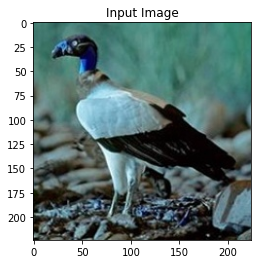

In [3]:
# Setup for Experiment

model = VGG16(include_top=True,weights="imagenet") # Input dims = 224 x 224 x 3
obstruction_size = (30, 30)
stride = (10, 10)

image = cv2.imread("../input/100-bird-species/train/KING VULTURE/074.jpg")
cached_image = image.copy()

plt.imshow(cached_image)
plt.title('Input Image')
plt.show()

In [4]:
# Instantiate OcclusionExp Class
occ = OcclusionExp(image, obstruction_size, stride, model)

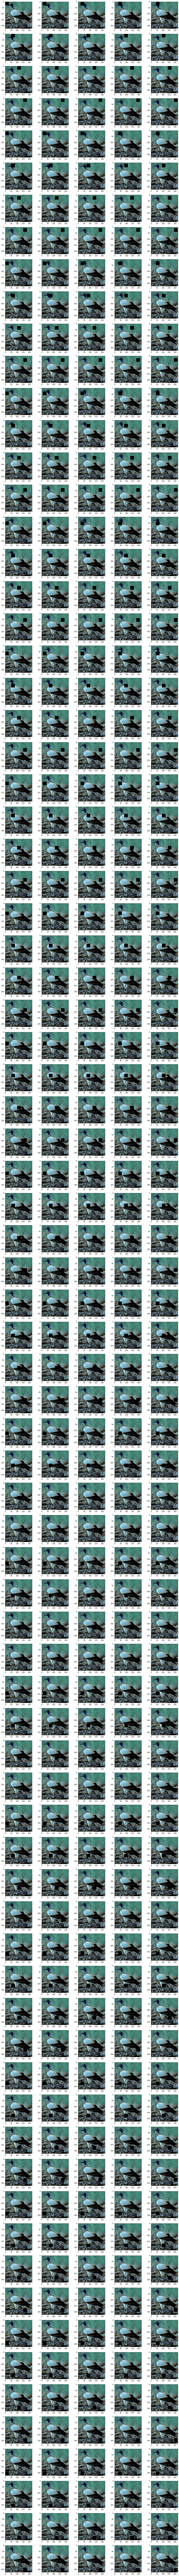

In [5]:
# Visualize occlusions
batch = occ.generate_occlusion()
cols = 5
rows = int(np.ceil(batch.shape[0] / cols))

fig, ax = plt.subplots(rows, cols, figsize=(20, 300))
for index in range(0, batch.shape[0]):
    row = index // cols
    col = index % cols
    
    ax[row][col].imshow(batch[index, :, :, :])

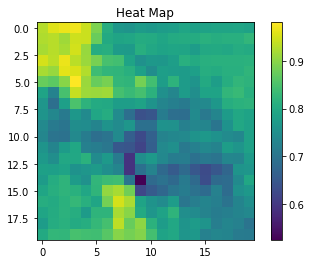

In [6]:
# Plot heat map
heat_map = occ.plot_hmap()

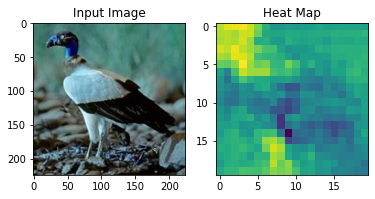

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(cached_image)
ax1.title.set_text('Input Image')
ax2.imshow(heat_map)
ax2.title.set_text('Heat Map')